# TESTS

In [16]:
from pathlib import Path
import os
import modflowapi
from modflowapi import Callbacks
from workflow import *
from datetime import datetime

DT_FMT = "%Y-%m-%d %H:%M:%S"


In [4]:
# sim = build_model(ws = 'model', sim_name = 'engesgaard1992')
# strt


In [5]:
# sim_ws = os.path.join('model', '1dtest', 'chloride')
sim_ws = Path("model/engesgaard1992/")
dll = Path("bin/win/libmf6")

In [ ]:
def try_get_value(address, mf6):
    try:
        res = mf6.get_value(address)
        return res
    except:
        res = 'failed'
        return res

In [11]:
mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()
# current_time = mf6.get_current_time()
# end_time = mf6.get_end_time()
all_vars = mf6.get_input_var_names() 

# var_add = 

# try:
#     mf6.finalize()
#     success=True
# except:
#     raise RuntimeError

In [16]:
list(set([var.split('/')[0] for var in all_vars]))

['__INPUT__',
 'GWF-GWT_4',
 'SLN_7',
 'TMPSLN_1',
 'GWF-GWT_2',
 'C',
 'SLN_8',
 'SLN_5',
 'SLN_3',
 'MG',
 'TMPSLN_2',
 'H',
 'CHARGE',
 'O',
 'GWF-GWT_6',
 'TMPSLN_8',
 'TDIS',
 'SLN_4',
 'TMPSLN_4',
 'CL',
 'SLN_6',
 'CA',
 'GWF-GWT_7',
 'GWF',
 'TMPSLN_3',
 'SLN_2',
 'SLN_1',
 'GWF-GWT_1',
 'TMPSLN_5',
 'TMPSLN_6',
 'GWF-GWT_5',
 'TMPSLN_7',
 'GWF-GWT_3']

In [ ]:
# current_time, end_time

# all_vars
df_vars = pd.DataFrame(all_vars)[0].str.split('/', expand=True)
df_vars['addr'] = all_vars
df_vars.to_csv('vars.csv')

In [ ]:
val = mf6.get_value(mf6.get_var_address("x", 'SODIUM'))
val += 1

# val = val + 1
val += 1
# mf6.get_value(mf6.get_var_address("x", 'SODIUM')) = val

In [ ]:
mf6.finalize()
val

In [ ]:

mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()

sim_start = datetime.now()
print("...starting transport solution at {0}".format(sim_start.strftime(DT_FMT)))
# reset the node tracking containers

# get the current sim time
ctime = mf6.get_current_time()
ctimes = [0.0]
# get the ending sim time
etime = mf6.get_end_time()
# max number of solution iterations
max_iter = mf6.get_value(mf6.get_var_address("MXITER", "SLN_1"))
num_fails = 0
# let's do it!
while ctime < etime:
    sol_start = datetime.now()
    # length of the current solve time
    dt = mf6.get_time_step()
    # prep the current time step
    mf6.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    mf6.prepare_solve(1)
    # the one-based stress period number
    stress_period = mf6.get_value(mf6.get_var_address("KPER", "TDIS"))[0]
    time_step = mf6.get_value(mf6.get_var_address("KSTP", "TDIS"))[0]

    # solve until converged
    while kiter < max_iter:
        # apply whatever change we want here
        # val = mf6.get_value(mf6.get_var_address("x", 'SODIUM'))
        # val += 1
        convg = mf6.solve(1)
        if convg:
            td = (datetime.now() - sol_start).total_seconds() / 60.0
            print("transport stress period,time step {0},{1} converged with {2} iters, took {3:10.5G} mins".format(stress_period, time_step, kiter,td))
            break
        kiter += 1

    if not convg:
        td = (datetime.now() - sol_start).total_seconds() / 60.0
        print("transport stress period,time step {0},{1} did not converged, {2} iters, took {3:10.5G} mins".format(
            stress_period, time_step, kiter, td))
        num_fails += 1
mf6.finalize()


In [ ]:
def callback_function(sim, callback_step):
    """
    A demonstration function that dynamically adjusts recharge
    and pumping in a modflow-6 model through the MODFLOW-API

    Parameters
    ----------
    sim : modflowapi.ApiSimulation
        A simulation object for the solution group that is
        currently being solved
    step : enumeration
        modflowapi.Callbacks enumeration object that indicates
        the part of the solution modflow is currently in.
    """
    ml = sim.get_model()
    if callback_step == Callbacks.initialize:
        print(sim.models)

    # if callback_step == Callbacks.stress_period_start:
    #     # adjust recharge for stress periods 7 through 12
    #     if sim.kper <= 6:
    #         rcha = ml.rcha_0
    #         spd = rcha.stress_period_data
    #         print(f"updating recharge: stress_period={ml.kper}")
    #         spd["recharge"] += 0.40 * sim.kper

    if callback_step == Callbacks.timestep_start:
        print(
            f"Testing: stress_period={ml.kper}, timestep={ml.kstp}", ml.kstp
        )
        if ml.kstp != 2:
            ml.wel.stress_period_data["q"] *= 1/ml.kstp
            # ml.wel.stress_period_data['CONCENTRATION'] = 100000000
            # print('..........................', ml.wel.stress_period_data['CONCENTRATION'])
        else:
            ml.wel.stress_period_data['q'] = 0
        # if ml.kstp ==2:
            
    if callback_step == Callbacks.iteration_start:
        # we can implement complex solutions to boundary conditions here!
        pass
    # return wel

# modflowapi.run_simulation(dll, sim_ws, callback_function, verbose=True)


In [ ]:
ucn = flopy.utils.HeadFile(os.path.join("model",'engesgaard1992',"sodium.ucn"),text="concentration")
carr = ucn.get_alldata()

In [ ]:
# carr[0][0]
carr[-1,0,0,:]

# PHREEQCRM TEST

In [5]:
import phreeqcrm
import numpy as np
import sys
import pandas as pd
from pathlib import Path
import os
import modflowapi
from modflowapi import Callbacks
from workflow import *
from datetime import datetime


In [20]:
print_selected_output_on = True
print_selected_output_on

True

In [16]:
nxyz = 50
nthreads = 1
phreeqc_rm = phreeqcrm.PhreeqcRM(nxyz, nthreads)

status = phreeqc_rm.SetComponentH2O(False)
phreeqc_rm.UseSolutionDensityVolume(False)
status = phreeqc_rm.SetFilePrefix("engesgaard1992")
phreeqc_rm.OpenFiles()
poro = np.full((nxyz), .1)
status = phreeqc_rm.SetPorosity(poro)

print_chemistry_mask = np.full((nxyz), 1)
status = phreeqc_rm.SetPrintChemistryMask(print_chemistry_mask)
nchem = phreeqc_rm.GetChemistryCellCount()
nchem

# init_file = 'phinp.dat'
init_file = 'advect.pqi'

# Load database
databasews = os.path.join("database", "pht3d_datab.dat")
status = phreeqc_rm.LoadDatabase(databasews)
status = phreeqc_rm.RunFile(True, True, True, init_file)# Clear contents of workers and utility
input = "DELETE; -all"
status = phreeqc_rm.RunString(True, False, True, input)

ncomps = phreeqc_rm.FindComponents()
ncomps

components = phreeqc_rm.GetComponents()
components

for comp in components:
    phreeqc_rm.OutputMessage(comp)
phreeqc_rm.OutputMessage("\n")

(50,)

50

('H', 'O', 'Charge', 'C', 'Ca', 'Cl', 'K', 'Mg', 'N', 'Na')

In [72]:


for comp in components:
    phreeqc_rm.OutputMessage(comp)
phreeqc_rm.OutputMessage("\n")

ic1 = [-1] * nxyz * 7 
ic1
for i in range(nxyz):
    ic1[i]            =  1  # Solution 1
    ic1[nxyz + i]     = 1  # Equilibrium phases none
    ic1[2 * nxyz + i] =  -1  # Exchange 1
    ic1[3 * nxyz + i] = -1  # Surface none
    ic1[4 * nxyz + i] = -1  # Gas phase none
    ic1[5 * nxyz + i] = -1  # Solid solutions none
    ic1[6 * nxyz + i] = -1  # Kinetics none

status = phreeqc_rm.InitialPhreeqc2Module(ic1)

# Initial equilibration of cells
time = 0.0
time_step = 0.0
status = phreeqc_rm.SetTime(time)
status = phreeqc_rm.SetTimeStep(time_step)
status = phreeqc_rm.RunCells()


In [73]:
status

c_dbl_vect = phreeqc_rm.GetConcentrations()


In [74]:
#ncomp * ncell

ncomps*nxyz, components


(350, ('H', 'O', 'Charge', 'C', 'Ca', 'Cl', 'Mg'))

In [75]:
phreeqc_rm.GetSpeciesNames()
phreeqc_rm.GetSpeciesConcentrations()

array([], dtype=float64)

In [76]:
phreeqc_rm.GetSpeciesNames()


('CH4',
 'CO2',
 'CO3-2',
 'Ca+2',
 'CaCO3',
 'CaHCO3+',
 'CaOH+',
 'Cl-',
 'H+',
 'H2',
 'H2O',
 'H2O-0.01',
 'HCO3-',
 'Mg+2',
 'MgCO3',
 'MgHCO3+',
 'MgOH+',
 'O2',
 'OH-')

In [77]:
phreeqc_rm.GetDatabaseFileName()
components
phreeqc_rm.GetEquilibriumPhases()
# phreeqc_rm.SetConcentrations()

('Calcite', 'Dolomite')

In [78]:
components

('H', 'O', 'Charge', 'C', 'Ca', 'Cl', 'Mg')

In [79]:
# status
c_dbl_vect = phreeqc_rm.GetConcentrations()

In [80]:
nlay = 1  # Number of layers
Lx = 0.5 #m
ncol = 50  # Number of columns
nrow = 1  

n=nxyz

conc = [c_dbl_vect[i:i + n] for i in range(0, len(c_dbl_vect), n)]

sconc = {}
for e, c in enumerate(components):
    sconc[c] = np.reshape(conc[e], (nlay, nrow, ncol))
sconc

for c in components:
    print(sconc[c].dtype)
# sconc


float64
float64
float64
float64
float64
float64
float64


In [4]:
ic1 = [-1] * 50 * 7 
len(ic1)

350

In [81]:
# sim = build_model(ws = 'model', sim_name = 'engesgaard1992', spls = components, sconc=sconc)

# strt

In [82]:
components

('H', 'O', 'Charge', 'C', 'Ca', 'Cl', 'Mg')

In [83]:
def flatten_list(xss):
    return [x for xs in xss for x in xs]


In [89]:
# sim_ws = os.path.join('model', '1dtest', 'chloride')
sim_ws = Path("model/engesgaard1992/")
dll = Path("bin/win/libmf6")

mf6 = modflowapi.ModflowApi(dll, working_directory = sim_ws)
mf6.initialize()


sim_start = datetime.now()
print("...starting transport solution at {0}".format(sim_start.strftime(DT_FMT)))
# reset the node tracking containers

# get the current sim time
ctime = mf6.get_current_time()
ctimes = [0.0]
# get the ending sim time
etime = mf6.get_end_time()
# max number of solution iterations
max_iter = mf6.get_value(mf6.get_var_address("MXITER", "SLN_2"))
num_fails = 0
# let's do it!
while ctime < etime:
    sol_start = datetime.now()
    # length of the current solve time
    dt = mf6.get_time_step()
    # prep the current time step
    mf6.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    mf6.prepare_solve(1)
    # the one-based stress period number
    stress_period = mf6.get_value(mf6.get_var_address("KPER", "TDIS"))[0]
    time_step = mf6.get_value(mf6.get_var_address("KSTP", "TDIS"))[0]

    # array to store transported components
    print(f'\nGetting concentration arrays --- time step: {time_step} --- elapsed time: {ctime}')
    mf6_conc_array = [mf6.get_value(mf6.get_var_address("X", f'{c.upper()}')) for c in components]
    c_dbl_vect = flatten_list(mf6_conc_array)

    phreeqc_rm.SetScreenOn(True)
    print_selected_output_on = (ctime == etime)
    print_chemistry_on = (ctime == etime)
    status = phreeqc_rm.SetSelectedOutputOn(True)
    status = phreeqc_rm.SetPrintChemistryOn(print_chemistry_on, False, False) 

    status = phreeqc_rm.SetConcentrations(c_dbl_vect)  
    message = 'Beginning reaction calculation               {} days\n'.format(ctime)
    phreeqc_rm.LogMessage(message)
    phreeqc_rm.ScreenMessage(message)
    status = phreeqc_rm.RunCells()

    # Transfer data from PhreeqcRM for transport
    #status = phreeqc_rm.GetConcentrations(c_dbl_vect)
    c_dbl_vect = phreeqc_rm.GetConcentrations()

    conc = [c_dbl_vect[i:i + n] for i in range(0, len(c_dbl_vect), n)]
    sconc = {}
    for e, c in enumerate(components):
        sconc[c] = np.reshape(conc[e], (nlay, nrow, ncol))

    # solve transport until converged
    for c in components:
        print(f'\nSolving for component: {c}')
        while kiter < max_iter:
            # print(list(mf6_conc_array))
            if c == 'mg':
                mf6.set_value(f'{c.upper()}/X', sconc[c]+100)
            else:
                mf6.set_value(f'{c.upper()}/X', sconc[c])
            convg = mf6.solve(1)
            if convg:
                td = (datetime.now() - sol_start).total_seconds() / 60.0
                print("Transport stress period: {0} --- time step: {1} --- converged with {2} iters --- took {3:10.5G} mins".format(stress_period, time_step, kiter,td))
                break
            kiter += 1

    if not convg:
        td = (datetime.now() - sol_start).total_seconds() / 60.0
        print("transport stress period {0}, time step {1}, did not converged, {2} iters, took {3:10.5G} mins".format(
            stress_period, time_step, kiter, td))
        num_fails += 1
    try:
        mf6.finalize_solve(1)
    except:
        pass
    mf6.finalize_time_step()
    # update the current time tracking
    ctime = mf6.get_current_time()
# sim = flopy.mf6.MFSimulation.load('engesgaard1992', 'mf6', 'mf6' , os.path.join('model', 'engesgaard1992'))
# plot_concentrations(sim)
sim_end = datetime.now()
td = (sim_end - sim_start).total_seconds() / 60.0
print("\n...transport solution finished at {0}, took: {1:10.5G} mins".format(sim_end.strftime(DT_FMT),td))
if num_fails > 0:
    print("...failed to converge {0} times".format(num_fails))
print("\n")
status = phreeqc_rm.CloseFiles()
status = phreeqc_rm.MpiWorkerBreak()
mf6.finalize()

...starting transport solution at 2024-05-22 10:09:08

Getting concentration arrays --- time step: 1 --- elapsed time: 0.0

Solving for component: H
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00036545 mins

Solving for component: O
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00038212 mins

Solving for component: Charge
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00039878 mins

Solving for component: C
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took  0.0004155 mins

Solving for component: Ca
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00043212 mins

Solving for component: Cl
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took  0.0004572 mins

Solving for component: Mg
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00047395 mins

Getting concen

In [86]:
[c_dbl_vect[i:i + n] for i in range(0, len(c_dbl_vect), n)]
sconc

{'H': array([[[111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812,
          111569.812, 111569.812, 111569.812, 111569.812, 111569.812]]]),
 'O': array([[[885480.57100003, 885480.57100003, 885480.57100003,
          885480.57100003, 885480.57100003, 885480.57100003,
          885480.57100003, 885480.57100003, 885480.57100003,
          885480.57100003, 885480.57100003, 885480.57100003,
          885480.57100003, 885480.57100003

In [87]:
sim = flopy.mf6.MFSimulation.load('engesgaard1992', 'mf6', 'mf6', sim_ws, verbosity_level=0)

sim.model_names
plot_concentrations(sim)

saving figures for engesgaard1992
saving figures for component: h
saving figures for component: o
saving figures for component: charge
saving figures for component: c
saving figures for component: ca
saving figures for component: cl
saving figures for component: mg


['h', 'o', 'charge', 'c', 'ca', 'cl', 'mg']

# Engesgaard 1992 - PHT3D

In [21]:
wd = os.path.join('benchmark', 'pht3d')
dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)
# simdf.columns = [col.lower() for col in simdf.columns]
simdf.loc[:, 'x'] = simdf['cell'] * dx 
simdf.head()


,cell,pH,pe,Ca,Cl,C4,Mg,Calcite,Dolomite,x
time_d,,,,,,,,,,
0.01,1.0,9.7017,-6.5533,0.000131,0.001121,0.0,0.000515,0.000000,0.000045,0.01
0.01,2.0,9.8379,-6.7482,0.000165,0.000373,0.0,0.000130,0.000000,0.000057,0.02
0.01,3.0,9.9058,-6.8288,0.000125,0.000092,0.0,0.000046,0.000115,0.000000,0.03
0.01,4.0,9.9087,-6.8347,0.000123,0.000024,0.0,0.000012,0.000120,0.000000,0.04
0.01,5.0,9.9095,-6.8362,0.000123,0.000007,0.0,0.000003,0.000122,0.000000,0.05


c:\Users\portega\anaconda3\envs\mf6rtm\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
c:\Users\portega\anaconda3\envs\mf6rtm\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
c:\Users\portega\anaconda3\envs\mf6rtm\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.


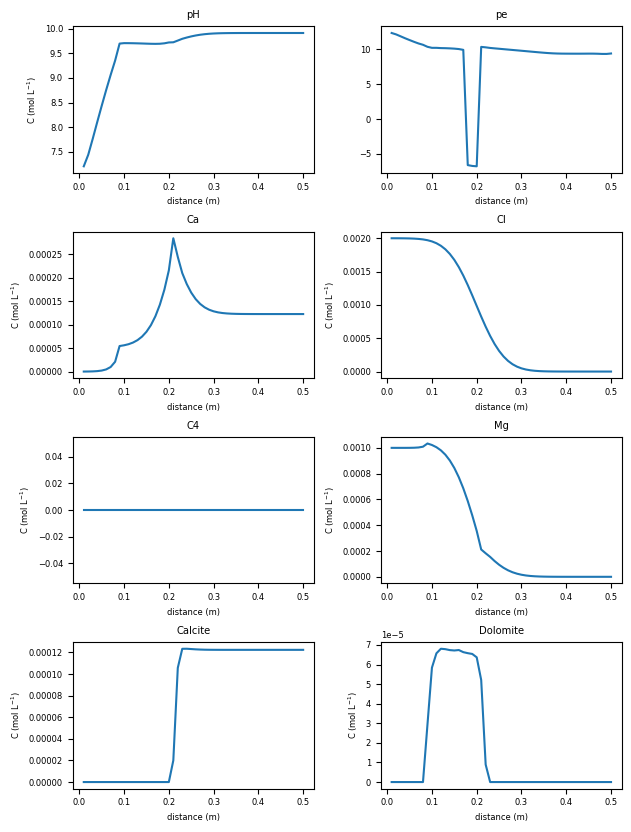

In [22]:
fig, axs = plt.subplots(4,2, figsize = (6.3, 8.3))
t = 0.24
for var, ax in zip(simdf.iloc[:,1:-1 ].columns, axs.flatten()):
    ax.plot(simdf.x.unique(), simdf.loc[t, var])
    ax.set_xlabel('distance (m)')
    if var not in ['ph', 'pe']:
        ax.set_ylabel('C (mol L$^{-1}$)')
    ax.set_title(f'{var}')

fig.tight_layout()

<Axes: xlabel='x'>

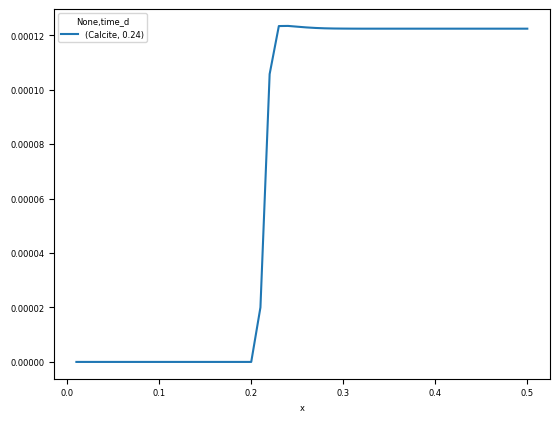

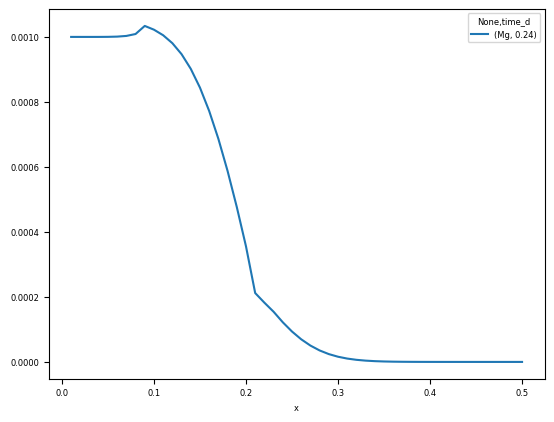

In [27]:
simdf.loc[0.24, ['x','Calcite']].pivot_table(index='x', columns = 'time_d').plot();
simdf.loc[0.24, ['x','Mg']].pivot_table(index='x', columns = 'time_d').plot() 

# Engesgaard 1992 - MF6RTM

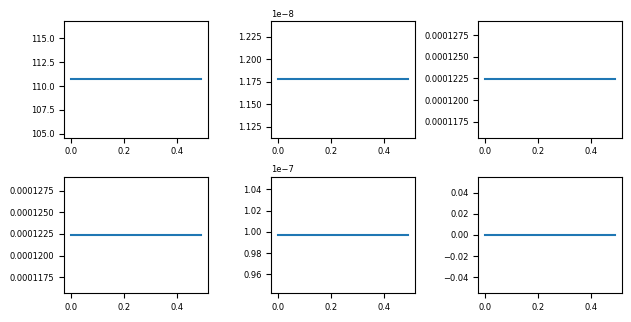

In [81]:
sim_ws = os.path.join('model', 'engesgaard1992')
sim = flopy.mf6.MFSimulation.load('engesgaard1992', 'mf6', 'mf6', sim_ws, verbosity_level=0)

comp = sim.model_names[1:]
comp = [c.capitalize() for c in comp if c !='o']
comp

dist_arr = np.arange(0, 50*dx, dx)
gwf = sim.get_model('gwf')

fig, axs = plt.subplots(2, 3, figsize=(6.3,3.2))
for ax, c in zip(axs.flatten(), comp):
        ucn = flopy.utils.HeadFile(os.path.join("model",sim.name,f"{c}.ucn"),text=f"concentration")
        results = ucn.get_alldata()
        # results = gwf.output.concentration().get_alldata()
        times = gwf.output.concentration().get_times()

        tf = times[-1]
        r_tf = results[0, 0, 0,:]
        ax.plot(dist_arr, r_tf)

fig.tight_layout()

In [84]:
comp

['H', 'Charge', 'C', 'Ca', 'Cl', 'Mg']

50

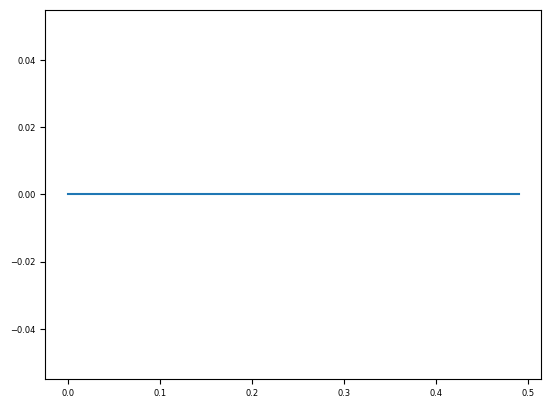

In [71]:
dist_arr = np.arange(0, 50*dx, dx)
plt.plot(dist_arr, results[-1, 0, 0,:])
len(dist_arr)